A. Correlation coefficients of the aforementioned variables.

Correlation coefficients:
               Apps    Enroll  Outstate  Top10perc  Top25perc  Grad.Rate
Apps       1.000000  0.846822  0.050159   0.338834   0.351640   0.146755
Enroll     0.846822  1.000000 -0.155477   0.181294   0.226745  -0.022341
Outstate   0.050159 -0.155477  1.000000   0.562331   0.489394   0.571290
Top10perc  0.338834  0.181294  0.562331   1.000000   0.891995   0.494989
Top25perc  0.351640  0.226745  0.489394   0.891995   1.000000   0.477281
Grad.Rate  0.146755 -0.022341  0.571290   0.494989   0.477281   1.000000


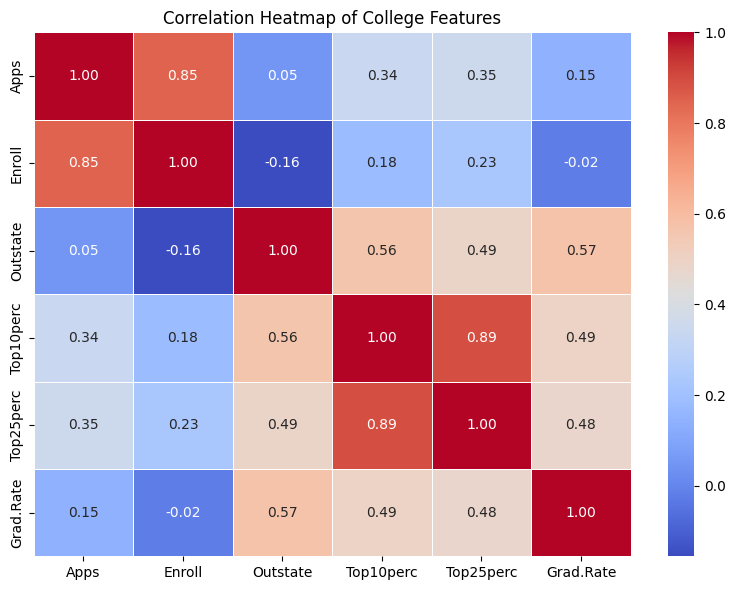

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset 
college_data = pd.read_csv("College data.csv")

# Checking for required columns
college_data.columns

# Selecting the required columns
required_columns = ['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc', 'Grad.Rate']

# Calculating the correlation matrix 
correlation_matrix = college_data[required_columns].corr()

# Correlation matrix
print("Correlation coefficients:")
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of College Features")
plt.tight_layout()
plt.show()

B. Stepwise linear regression on the independent variables

In [2]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Independent variables
X = college_data[['Apps', 'Enroll','Top10perc','Outstate', 'Top25perc']]

# Dependent variables
y = college_data['Grad.Rate']


# a constant 
X = sm.add_constant(X)

# Split the model
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Forward selection
def forward_stepwise(X,y, threshold_in=0.05):
    var_included =[]
    while True:
        var_excluded = list(set(X.columns)-set(var_included))
        p_value_new = pd.Series(index=var_excluded)
        for new_column in var_excluded:
            model = sm.OLS(y, X[var_included + [new_column]]).fit()
            p_value_new[new_column] =model.pvalues[new_column]
        p_value_best = p_value_new.min()
        if p_value_best < threshold_in:
            best_features = p_value_new.idxmin()
            var_included.append(best_features)
        else:
            break
    return var_included
# Running the forward selection 
stepwise_features_selected = forward_stepwise(X_train, y_train)

# Fitting the model 
stepwise_model_fit = sm.OLS(y_train, X_train[stepwise_features_selected]).fit()

# Summary 
print(stepwise_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Grad.Rate   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     171.6
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           5.24e-60
Time:                        13:26:18   Log-Likelihood:                -2524.7
No. Observations:                 621   AIC:                             5055.
Df Residuals:                     618   BIC:                             5069.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Outstate       0.0019      0.000     11.567      0.0

C. Identify the predictor variables that are useful in the prediction

In [3]:
# Print the selected predictor variables, including the constant
print("The predictor variables that are useful are ", stepwise_features_selected)


The predictor variables that are useful are  ['Outstate', 'const', 'Top25perc']


D. Use BIC to select the model, based on the given independent variables

In [4]:
import pandas as pd
import statsmodels.api as sm
import itertools


def calculate_BIC(X, y):
    model = sm.OLS(y, X).fit()
    return model.bic

# best BIC model
BIC_model_best = float('inf')
best_model = None
BIC_best_features = []

# Iteration over combinations of features
independent_variables = X.columns[1:]  
for i in range(1, len(independent_variables) + 1):
    for combination in itertools.combinations(independent_variables, i):
        # Fitting 
        X_selected = X[list(combination)]
        calculated_BIC = calculate_BIC(X_selected, y)
        
        # best BIC
        if calculated_BIC < BIC_model_best:
            BIC_model_best = calculated_BIC
            best_model = X_selected
            BIC_best_features = combination

# best BIC value and selected features
print("The best BIC value is ", BIC_model_best)
print("The best selected features are ", BIC_best_features)

# Fit the best model 
best_model_fit = sm.OLS(y, best_model).fit()

# summary
print(best_model_fit.summary())


The best BIC value is  6511.511636230451
The best selected features are  ('Top10perc', 'Outstate', 'Top25perc')
                                 OLS Regression Results                                
Dep. Variable:              Grad.Rate   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              4491.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):                        0.00
Time:                        13:26:18   Log-Likelihood:                         -3245.8
No. Observations:                 777   AIC:                                      6498.
Df Residuals:                     774   BIC:                                      6512.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
        

In [5]:
from sklearn.metrics import mean_squared_error

# Running the forward selection
stepwise_features_selected = forward_stepwise(X_train, y_train)

# Fitting the Stepwise model
stepwise_model_fit = sm.OLS(y_train, X_train[stepwise_features_selected]).fit()

# R-squared and MSE 
bic_r_squared = best_model_fit.rsquared
bic_mse = mean_squared_error(y_test, best_model_fit.predict(X_test[list(BIC_best_features)]))

stepwise_r_squared = stepwise_model_fit.rsquared
stepwise_mse = mean_squared_error(y_test, stepwise_model_fit.predict(X_test[stepwise_features_selected]))

# Print 
print(f"Stepwise Model - R-squared is {stepwise_r_squared}, MSE is {stepwise_mse}")
print(f"BIC Model - R-squared is {bic_r_squared}, MSE is {bic_mse}")


Stepwise Model - R-squared is 0.3570840020704218, MSE is 121.50146022950824
BIC Model - R-squared is 0.9456730466797645, MSE is 188.43260861545392


E. Compare the accuracy of the model using only useful predictors with the accuracy of the model using all five predictors?

In [6]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# best features from the BIC model
useful_predictors = sm.OLS(y_train, X_train[list(BIC_best_features)]).fit()

# Fit a model using all five predictors
five_predictors = sm.OLS(y_train, X_train[['Apps', 'Enroll', 'Top10perc', 'Outstate', 'Top25perc']]).fit()

# R-squared and MSE for both models
useful_r2 = useful_predictors.rsquared
useful_mse = mean_squared_error(y_test, useful_predictors.predict(X_test[list(BIC_best_features)]))

fivepredictors_r2 = five_predictors.rsquared
fivepredictors_mse = mean_squared_error(y_test, five_predictors.predict(X_test[['Apps', 'Enroll', 'Top10perc', 'Outstate', 'Top25perc']]))

# Print accuracy metrics
print(f"useful predictors model - R-squared is {useful_r2} and MSE is {useful_mse}")
print(f"five predictors model - R-squared is {fivepredictors_r2} and  MSE is {fivepredictors_mse}")


useful predictors model - R-squared is 0.9422895033020046 and MSE is 189.467931408217
five predictors model - R-squared is 0.9423808339385041 and  MSE is 185.77194532990637


F. Calculate the graduation rate for CMU with the most accurate model.

In [7]:
# Extract CMU data
yaleuni_data = college_data[college_data['Unnamed: 0'] == 'Yale University'].iloc[0]

# Predictors used in the BIC model
selected_predictors = ['Top10perc', 'Outstate', 'Top25perc']

# input for prediction
yale_X = [yaleuni_data[predictor] for predictor in selected_predictors]

# Convert to DataFrame for prediction
yale_X_df = pd.DataFrame([yale_X], columns=selected_predictors)

# Prediction using the BIC model
yale_predictions = best_model_fit.predict(yale_X_df)

# Output the predicted graduation rate
print(f"Predicted Graduation rate for Yale University is {yale_predictions[0]}%")

Predicted Graduation rate for Yale University is 88.8466785502595%
